# Ramachandran outliers

The goal here is to find the aminoacids present in the excluded volume and save their location to determine the possible mistakes in the database or shortcomings of the phi-psi finding code

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.colors as colors
from matplotlib import cm

from my_utilities.data import get_data
from my_utilities.ramachandran import get_ramachandran, plot_ramachandran
from my_utilities.matrix_representations import limited_SVD_representation
from my_utilities.density import get_g_hist_linear, get_g_hist_trivial
from my_utilities.metrics import log_likelihood

## Excluded volume
first we have to get info on excluded volume.

In [5]:
! ls -1 ./pyrosetta/exclmap*.csv

./pyrosetta/exclmap128.csv
./pyrosetta/exclmap256.csv
./pyrosetta/exclmap32.csv
./pyrosetta/exclmap64.csv


We have already created exluded volume masks for n_bins $\in \{32,64,128,256\}$ so we'll take the largest resolution one to find the outliers

In [52]:
excluded_volume_mask = ~pd.read_csv(f"./pyrosetta/exclmap256_30.csv").to_numpy()

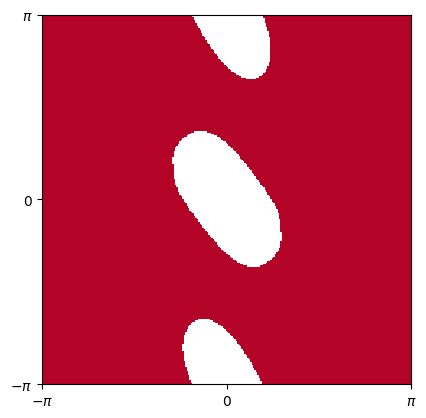

In [53]:
plot_ramachandran(excluded_volume_mask)

## Data

In [9]:
datfiles_dir = "./dat_files1/"
pdb_entries = os.listdir(datfiles_dir)

In [54]:
# previously created method get_data does not distinguish between files, so we'll do it manually
data_list = []
for filename in pdb_entries:
    with open(f"{datfiles_dir}{filename}") as file_content:
        for line_num, line in enumerate(file_content.readlines()):
            row = line.split()
            # we want to eliminate rows with lacking columns
            if len(row) == 8:
                data_list.append([filename, # pdb id
                                  line_num, # num of line in the pdb file
                                  str(row[0]),
                                  str(row[1]),
                                  int(row[2]),
                                  str(row[3]),
                                  str(row[4]),
                                  str(row[5]),
                                  float(row[6]),
                                  float(row[7])])
data =  pd.DataFrame(data_list,
                     columns=["filename",
                              "line_num",
                              "pdb_code",
                              "chain_code",
                              "aa_num_in_sequence",
                              "aa_3l_code",
                              "aa_triplet",
                              "2nd_struct",
                              "phi", "psi"])

In [57]:
n = excluded_volume_mask.shape[0]
dx = 2 * np.pi / n

data["outlier"] = data.apply(lambda row:
                             ~ excluded_volume_mask[
                                 tuple(((np.array([row["phi"],row["psi"]]) + np.pi) // dx).astype(int))
                             ],
                             axis=1
                            )

/home/pt/miniconda3/envs/surpass1/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


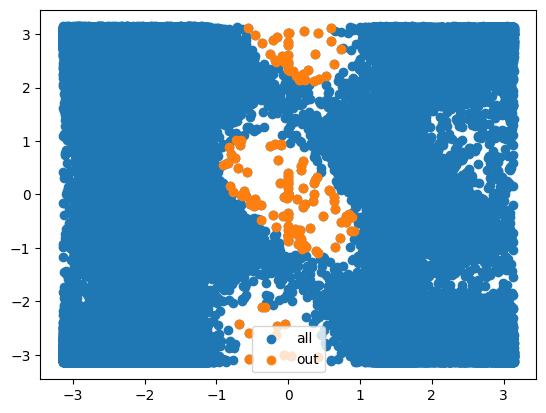

In [59]:
points_all = data[["phi", "psi"]].values
points_out = data[data["outlier"]][["phi", "psi"]].values
plt.scatter(points_all[:,0], points_all[:,1], label="all")
plt.scatter(points_out[:,0], points_out[:,1], label="out")
plt.legend()
plt.show()

In [60]:
len(data)

2420123

In [63]:
data[data["outlier"]]

,filename,line_num,pdb_code,chain_code,aa_num_in_sequence,aa_3l_code,aa_triplet,2nd_struct,phi,psi,outlier
13159,5zm0.dat,0,5ZM0,A,4,VAL,GVK,CCC,0.000000,2.846584,True
14534,1vrz.dat,0,1VRZ,A,3,23F,GFA,HHH,0.000000,0.000000,True
14535,1vrz.dat,1,1VRZ,A,4,ALA,FAF,HHH,0.000000,0.000000,True
14536,1vrz.dat,2,1VRZ,A,5,23F,AFF,HHH,0.000000,0.000000,True
14537,1vrz.dat,3,1VRZ,A,6,23F,FFA,HHH,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...
2249160,3nzb.dat,82,3NZB,X,84,GLU,NES,CCC,-0.699860,0.498866,True
2249161,3nzb.dat,83,3NZB,X,85,SER,ESL,CCC,-0.690296,-2.427220,True
2311556,3vl1.dat,46,3VL1,A,48,GLY,LGN,CCC,-0.670316,0.932704,True
2329832,4a4y.dat,123,4A4Y,A,125,HIS,NHS,CCC,-0.050638,-2.418998,True


In [62]:
data[data["outlier"]].to_csv("./outliers1.csv")

In [ ]:
plt.scatter(point1[0], point1[1])
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.show()

In [ ]:
excluded_volume_mask1 = np.copy(excluded_volume_mask)
excluded_volume_mask1

In [ ]:
plt.imshow(excluded_volume_mask)

(array([1.191980e+05, 4.688300e+05, 6.386700e+05, 1.038681e+06,
        7.430000e+02, 6.340000e+02, 6.661000e+04, 6.700800e+04,
        1.021200e+04, 9.537000e+03]),
 array([-3.1415820e+00, -2.5132657e+00, -1.8849494e+00, -1.2566331e+00,
        -6.2831680e-01, -5.0000000e-07,  6.2831580e-01,  1.2566321e+00,
         1.8849484e+00,  2.5132647e+00,  3.1415810e+00]),
 <BarContainer object of 10 artists>)

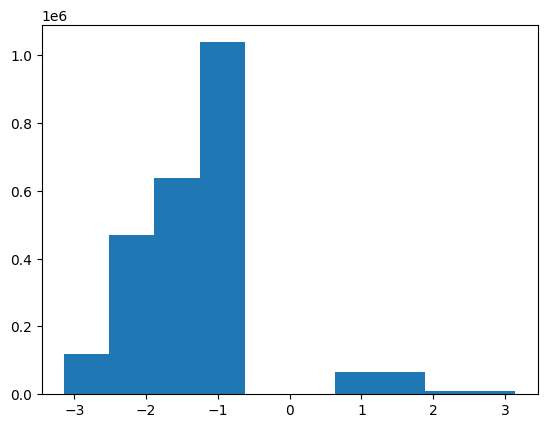

In [17]:
plt.hist(data[["phi","psi"]].values[:,0])